## Final Project Submission

Please fill out:
* Student name: Aaron Lee
* Student pace: self paced
* Scheduled project review date/time: #########
* Instructor name: Jeff Herman
* Blog post URL: ###########


# Access TMDB database


This data project will investigate the relationship between the running time of a movie, and its potential revenue production.

In [46]:
# Access TMDB
import json
import pandas as pd

def get_keys(path):
    with open(path) as f:
        return json.load(f)
    

keys = get_keys("/Users/aaronlee/.secret/tmdb_api.json")

api_key = keys['api_key']
api_key4 = keys['api_key4']


We will be using "The Movie Database" (TMDB) API to access the the box office info we need for this project.  Below are some examples of API calls for TMDB.  

In [47]:
# useful urls to access tmdb
base_url = 'https://api.themoviedb.org/3/'
# /person/person_id, /movie/movie_id, /keywords/[keys] , 


# HOW TO ACCESS DB
# 2017 highest grossing
params = {'primary_release_year': 2017,
          'sort_by': 'revenue.desc'
         }

# highest revenue Tom Cruise scifi movie
params = {'with_genres': 878,
          'with_cast': 500,
          'sort_by': 'revenue.desc'
        }


# Commented out below is a proper request

#response = requests.get(base_url + 'discover/movie?api_key=' +  api_key, params=params)
# the movies for the retrieved page is located in response.json()['results']


We will create an API request to get the last five years of movies sorted by budget.  This will give a good cross section of movies which have gone into wide theater release.  We will choose not to use data from 2020 due to the COVID-19 pandemic.

In [48]:
import requests


# We will get the top n(sample size) number of movies from the indicated range of years
# TMDB displays 20 per page.  Thats 50 pages worth!

def movie_selection_response(n, start_year, end_year):
    """Get a list of movie data.
    Args:
        n (int): number of movies to grab.
        start_year (int): earliest production year for movies returned
        end_year (int): latest production year for movies returned
    Returns:
       list: each index is a dict representing api results for single movie.
    """
    pages = 1 + n // 20 # db returns 20 results per page
    list_of_dicts = []  # list to be returned
    
    for i in range(1, pages + 1):
        # each iteration and api call is for a single page (20 movies)
        params = {'primary_release_year.gte': str(start_year),
                  'primary_release_year.lte': str(end_year),
                  'sort_by': 'revenue.desc',
                  'page': i,
                  'adult': False}
        
        #Fetch Movie Data
        print("Fetching page {}".format(i))
        response = requests.get(base_url + 'discover/movie?api_key=' +  api_key, params=params)
        
        # Go through results and add each to movie dict
        for movie in response.json()['results']:
            list_of_dicts.append(movie)
    
    return list_of_dicts[:n]

sample_size = 1000
all_my_movies = movie_selection_response(sample_size, 2015, 2019)
print(all_my_movies)


Fetching page 1
Fetching page 2
Fetching page 3
Fetching page 4
Fetching page 5
Fetching page 6
Fetching page 7
Fetching page 8
Fetching page 9
Fetching page 10
Fetching page 11
Fetching page 12
Fetching page 13
Fetching page 14
Fetching page 15
Fetching page 16
Fetching page 17
Fetching page 18
Fetching page 19
Fetching page 20
Fetching page 21
Fetching page 22
Fetching page 23
Fetching page 24
Fetching page 25
Fetching page 26
Fetching page 27
Fetching page 28
Fetching page 29
Fetching page 30
Fetching page 31
Fetching page 32
Fetching page 33
Fetching page 34
Fetching page 35
Fetching page 36
Fetching page 37
Fetching page 38
Fetching page 39
Fetching page 40
Fetching page 41
Fetching page 42
Fetching page 43
Fetching page 44
Fetching page 45
Fetching page 46
Fetching page 47
Fetching page 48
Fetching page 49
Fetching page 50
Fetching page 51
[{'popularity': 0, 'vote_count': 0, 'video': False, 'poster_path': '/vhcakM12qXDGKTpcbOQTg1egDMB.jpg', 'id': 693704, 'adult': False, 'backdrop

We have retrieved the basic info for each movie which also contains the movie 'id' number.
We now extract all the movie 'id's.

In [49]:
all_my_movies[0]  # look at data for first movie

# lets grab all of the movie numbers
movie_ids = [movie['id'] for movie in all_my_movies]

movie_ids.pop(0)

693704

Now that we can the movie 'id' for TMDB, we can do a detailed movie api call for all of the selected movies.  This data includes: title, revenue, budget, runtime, etc.  



In [50]:
all_movie_details = []

i = 1

for movie in movie_ids:
    #Fetch Movie Data
    print(movie)
    movie_response = requests.get(base_url + 'movie/' + str(movie) + '?api_key=' +  api_key)
    print(movie_response)
    all_movie_details.append(movie_response.json())
    i += 1



299534
<Response [200]>
19995
<Response [200]>
140607
<Response [200]>
299536
<Response [200]>
597
<Response [200]>
135397
<Response [200]>
420818
<Response [200]>
24428
<Response [200]>
168259
<Response [200]>
99861
<Response [200]>
284054
<Response [200]>
12445
<Response [200]>
181808
<Response [200]>
330457
<Response [200]>
351286
<Response [200]>
109445
<Response [200]>
321612
<Response [200]>
260513
<Response [200]>
337339
<Response [200]>
68721
<Response [200]>
211672
<Response [200]>
271110
<Response [200]>
297802
<Response [200]>
429617
<Response [200]>
299537
<Response [200]>
38356
<Response [200]>
122
<Response [200]>
37724
<Response [200]>
91314
<Response [200]>
49026
<Response [200]>
475557
<Response [200]>
181812
<Response [200]>
301528
<Response [200]>
10193
<Response [200]>
58
<Response [200]>
330459
<Response [200]>
420817
<Response [200]>
1865
<Response [200]>
324852
<Response [200]>
127380
<Response [200]>
12155
<Response [200]>
269149
<Response [200]>
49051
<Response

<Response [200]>
13448
<Response [200]>
14
<Response [200]>
72545
<Response [200]>
568
<Response [200]>
380
<Response [200]>
10567
<Response [200]>
49538
<Response [200]>
402
<Response [200]>
710
<Response [200]>
640
<Response [200]>
392044
<Response [200]>
9740
<Response [200]>
854
<Response [200]>
381719
<Response [200]>
64682
<Response [200]>
1637
<Response [200]>
153518
<Response [200]>
8656
<Response [200]>
181533
<Response [200]>
73723
<Response [200]>
400650
<Response [200]>
198663
<Response [200]>
43956
<Response [200]>
2059
<Response [200]>
77931
<Response [200]>
5175
<Response [200]>
2048
<Response [200]>
136799
<Response [200]>
47971
<Response [200]>
10530
<Response [200]>
8871
<Response [200]>
188927
<Response [200]>
7518
<Response [200]>
55301
<Response [200]>
888
<Response [200]>
447332
<Response [200]>
4523
<Response [200]>
53182
<Response [200]>
414
<Response [200]>
9543
<Response [200]>
9802
<Response [200]>
291805
<Response [200]>
58574
<Response [200]>
36218
<Respons

<Response [200]>
224141
<Response [200]>
10202
<Response [200]>
1844
<Response [200]>
9273
<Response [200]>
8619
<Response [200]>
1493
<Response [200]>
9946
<Response [200]>
95610
<Response [200]>
228150
<Response [200]>
41733
<Response [200]>
1495
<Response [200]>
10144
<Response [200]>
17654
<Response [200]>
698
<Response [200]>
197
<Response [200]>
1933
<Response [200]>
51540
<Response [200]>
508747
<Response [200]>
9533
<Response [200]>
158852
<Response [200]>
11774
<Response [200]>
59961
<Response [200]>
151743
<Response [200]>
296096
<Response [200]>
1900
<Response [200]>
9799
<Response [200]>
9800
<Response [200]>
138103
<Response [200]>
2668
<Response [200]>
9325
<Response [200]>
267860
<Response [200]>
72571
<Response [200]>
820
<Response [200]>
117251
<Response [200]>
20943
<Response [200]>
9767
<Response [200]>
38167
<Response [200]>
9477
<Response [200]>
253412
<Response [200]>
1903
<Response [200]>
329865
<Response [200]>
136797
<Response [200]>
44943
<Response [200]>
1242

In [32]:
all_movie_details[0]

[{'adult': False,
  'backdrop_path': '/orjiB3oUIsyz60hoEqkiGpy5CeO.jpg',
  'belongs_to_collection': {'id': 86311,
   'name': 'The Avengers Collection',
   'poster_path': '/bvjltR2nDuhf1NlnwCrgNwvHuIh.jpg',
   'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
  'budget': 356000000,
  'genres': [{'id': 12, 'name': 'Adventure'},
   {'id': 878, 'name': 'Science Fiction'},
   {'id': 28, 'name': 'Action'}],
  'homepage': 'https://www.marvel.com/movies/avengers-endgame',
  'id': 299534,
  'imdb_id': 'tt4154796',
  'original_language': 'en',
  'original_title': 'Avengers: Endgame',
  'overview': "After the devastating events of Avengers: Infinity War, the universe is in ruins due to the efforts of the Mad Titan, Thanos. With the help of remaining allies, the Avengers must assemble once more in order to undo Thanos' actions and restore order to the universe once and for all, no matter what consequences may be in store.",
  'popularity': 51.081,
  'poster_path': '/or06FN3Dka5tukK1e9sl16pB3iy

With detailed info on every movie in our search, we can finally put it all into a Panda dataframe for further investigation.  We will attempt to look at major trends in movies for a new production company, so we will check the data as it relates primarily to budget and revenue.  We will attempt to inform the company what types of movies will be profitable going forward. 

In [59]:
all_movie_details[0]['runtime']  # each list item is a movie dict


df = pd.DataFrame(all_movie_details)
df = df[(df['vote_count'] > 0) & (df['runtime'] > 60) & (df['revenue'] > 5e5) & (df['budget'] > 5e5)]  # get rid of shorts and non voted

df.isna().sum()  # all the data will work for our purposes.  We might later drop some cols to simplify
    




adult                      0
backdrop_path              8
belongs_to_collection    455
budget                     0
genres                     0
homepage                   1
id                         0
imdb_id                    0
original_language          0
original_title             0
overview                   0
popularity                 0
poster_path                0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                    0
spoken_languages           0
status                     0
tagline                    0
title                      0
video                      0
vote_average               0
vote_count                 0
status_code              967
status_message           967
dtype: int64

In [60]:
df.iloc[1]['belongs_to_collection']


{'id': 87096,
 'name': 'Avatar Collection',
 'poster_path': '/nslJVsO58Etqkk17oXMuVK4gNOF.jpg',
 'backdrop_path': '/8nCr9W7sKus2q9PLbYsnT7iCkuT.jpg'}

Our investigation will be focused on the budget and revenues of movies. 
We begin by exploring these for our set of movies.

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Budget Centeral Tendency")
print('Mean Budget: {:.2f} Million'.format(df['budget'].mean() / 1e6))
print('Median Budget: {:.2f} Million'.format(df['budget'].median() / 1e6))
print('First Quartile (25%): {:.2f} Million'.format(df['budget'].quantile(0.25) / 1e6))
print("IQR (25-50%): {:.2f} Million".format((df['budget'].quantile(0.75) - df['budget'].quantile(0.25)) / 1e6))
print("Std Dev: {:.2f} Million".format(df['budget'].std() / 1e6))

print("\nRevenue Central Tendency")
print('Mean Revenue: {:.2f} Million'.format(df['revenue'].mean() / 1e6))
print('Median Revenue: {:.2f} Million'.format(df['revenue'].median() / 1e6))
print('First Quartile (25%): {:.2f} Million'.format(df['revenue'].quantile(0.25) / 1e6))
print("IQR (25-50%): {:.2f} Million".format((df['revenue'].quantile(0.75) - df['revenue'].quantile(0.25)) / 1e6))
print("Std Dev: {:.2f} Million".format(df['revenue'].std() / 1e6))


# df.info()
# df.describe()
# df['budget'].describe()
# df['revenue'].describe()




Budget Centeral Tendency
Mean Budget: 90.72 Million
Median Budget: 80.00 Million
First Quartile (25%): 40.00 Million
IQR (25-50%): 90.00 Million
Std Dev: 61.28 Million

Revenue Central Tendency
Mean Revenue: 392.90 Million
Median Revenue: 295.21 Million
First Quartile (25%): 210.15 Million
IQR (25-50%): 247.05 Million
Std Dev: 289.54 Million


[Text(0.5, 0, 'Millions (USD))')]

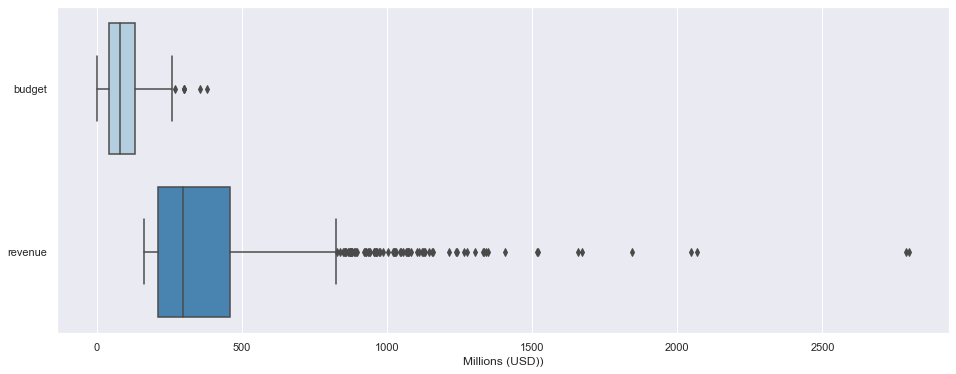

In [99]:
# df with just revenue and budget
df_returns = df[['budget', 'revenue']].copy()

sns.set_style('darkgrid')
dims = (6, 18)

# df with just revenue and budget
df_returns = df[['budget', 'revenue']].copy()

sns.set_style('darkgrid')
sns.set_context("notebook")


dims = (18, 6)


#sns.boxplot(data=df_returns, palette='Reds')
# xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
# ax.set_title("Revenue for Major Theaterical Releases")
# ax.set_xticklabels(xlabels)
# ax.set(xlabel='Millions (USD)')

plt.figure(figsize=(16, 6))

ax = sns.boxplot(data=df_returns, palette='Blues', orient='h')
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ax.set(xlabel="Millions (USD))")



[Text(0.5, 0, 'Millions (USD)')]

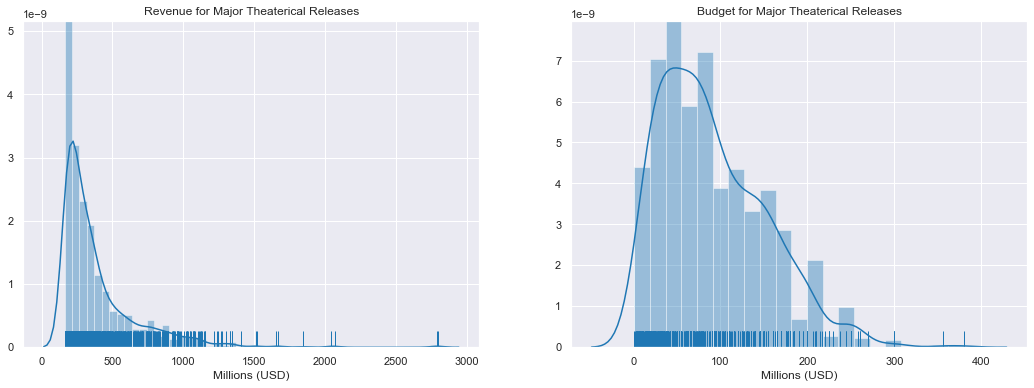

In [100]:


dims = (18, 6)
fig, ax = plt.subplots(1, 2, figsize=dims)

# Revenue regression plot
sns.distplot(df['revenue'], ax=ax[0], rug=True) 
ax[0].set_title("Revenue for Major Theaterical Releases")
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax[0].get_xticks()]
ax[0].set_xticklabels(xlabels)
ax[0].set(xlabel='Millions (USD)')


# Budget regression plot
sns.distplot(df['budget'], ax=ax[1], rug=True) 
ax[1].set_title("Budget for Major Theaterical Releases")
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax[1].get_xticks()]
ax[1].set_xticklabels(xlabels)
ax[1].set(xlabel='Millions (USD)')

Both budget and revenue are left skewed, and returns tend to be significantly higher than budgets, with revenue outliers on the high side being far more prevalent than budget outliers.

Now we will attempt to find correlations between movie attributes and the revenue data.
The data of interest will be: budget, genre, 



Text(0.5, 1, 'Pearson Coefficients')

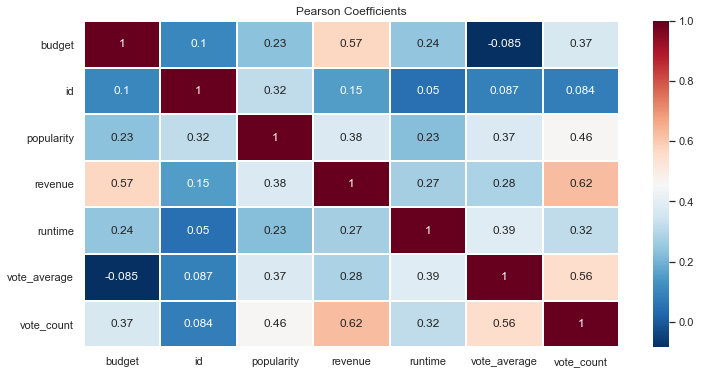

In [142]:
import numpy as np

try:
    df.drop(columns=['status_code', 'status_message'], inplace=True)
except:
    pass


pearsoncorr = df.corr(method ='pearson') 
plt.figure(figsize=(12,6))

# this works in matplotlib 
ax = sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=1)

#df.columns
ax.set_ylim(7.0, 0)
ax.set_title('Pearson Coefficients')


